# Waveform classification using calibration files in DS1

This notebook attempts to use a simple MLP classifier to differentiate between single-site and multi-site events in a germanium detector.

The analysis is only performed on one detector (Channel 626) which has the most accurate transfer functions for simulations.

In [ ]:
# Only uses Ch626 in DS1
# Import basic things
import numpy as np
import pandas as pd
import glob

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid') # Set style so background is white

In [3]:
# Read in files -- the files are stored as Pandas DataFrames
extDir = '/Users/brianzhu/project/Pandas/cal-skim'
sigFiles = glob.glob('%s/waveSkimDS1_run*.h5' % extDir)
dfSigFull = pd.DataFrame()
sigList = []
# Too many files in list, just use first 100
for f in sigFiles[:100]:
    try:
        dfDummy = pd.read_hdf(f,'skimTree')
        sigList.append(dfDummy)
    except:
        print ("%s is broken"%(f))
print ('Loaded %d files'%(len(sigList)))
dfSigFull = pd.concat(sigList)
# Prints out first 5 lines of the DataFrame
# Each sample of the waveform is saved as wave# (eg: the 1st sample is wave0)
# Some basic parameters are saved like channel, run, trapENFCal, avse, and dcr99
dfSigFull.head()

/Users/brianzhu/project/Pandas/cal-skim/waveSkimDS1_run10728.h5 is broken
/Users/brianzhu/project/Pandas/cal-skim/waveSkimDS1_run10950.h5 is broken
/Users/brianzhu/project/Pandas/cal-skim/waveSkimDS1_run11218.h5 is broken
Loaded 97 files


,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave1000,wave1001,...,wave990,wave991,wave992,wave993,wave994,wave995,wave996,wave997,wave998,wave999
0,1.0,-83.759123,626.0,-0.001324,1.0,10004.0,2613.018297,6332.061195,299.598,316.598,...,137.598,147.598,162.598,180.598,193.598,207.598,227.598,244.598,259.598,281.598
1,1.0,0.742406,626.0,-0.000348,1.0,10004.0,166.454222,6297.228554,352.014,365.014,...,121.014,144.014,165.014,196.014,225.014,254.014,279.014,298.014,321.014,337.014
2,1.0,0.196491,626.0,-0.000298,1.0,10004.0,143.571530,6241.195025,265.268,282.268,...,83.268,91.268,105.268,120.268,138.268,160.268,182.268,205.268,227.268,249.268
3,1.0,-15.399226,626.0,-0.000548,1.0,10004.0,693.177898,6280.520079,158.204,172.204,...,84.204,94.204,98.204,105.204,110.204,113.204,122.204,131.204,140.204,148.204
4,1.0,-0.430794,626.0,-0.000240,1.0,10004.0,276.364021,6267.693007,155.104,174.104,...,66.104,71.104,78.104,84.104,89.104,97.104,103.104,116.104,127.104,139.104


In [4]:
# Looking at the shape of the dataframe as well as the end
# The shape shows the # of events vs # of parameters
print dfSigFull.shape
dfSigFull.tail()

(765000, 1209)


,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave1000,wave1001,...,wave990,wave991,wave992,wave993,wave994,wave995,wave996,wave997,wave998,wave999
14995,1.0,0.581764,626.0,-0.000323,1.0,12660.0,113.970249,6276.937544,90.030,104.030,...,37.030,41.030,43.030,46.030,50.030,53.030,56.030,64.030,69.030,81.030
14996,1.0,0.431703,626.0,-0.000179,1.0,12660.0,241.118864,6282.813844,56.156,55.156,...,31.156,32.156,36.156,36.156,41.156,41.156,42.156,45.156,49.156,50.156
14997,1.0,0.903754,626.0,-0.000303,1.0,12660.0,194.107724,6308.333868,387.658,406.658,...,111.658,130.658,154.658,184.658,209.658,247.658,279.658,313.658,340.658,367.658
14998,1.0,-1.383040,626.0,-0.000364,1.0,12660.0,183.510218,6208.408927,92.902,101.902,...,45.902,49.902,51.902,55.902,58.902,59.902,61.902,69.902,73.902,81.902
14999,1.0,-0.323492,626.0,-0.000302,1.0,12660.0,2416.167343,6363.989016,322.060,338.060,...,130.060,151.060,169.060,187.060,207.060,227.060,246.060,263.060,283.060,299.060


In [5]:
# The index (1st column) gets duplicated -- this is because the index resets for every file
# We can reset the index column -- this assures a unique index value for each event
dfSigReset = dfSigFull.reset_index()

# Check indices are correct now -- the previous index column is now called "index"
# We can rename it if it's confusing
print dfSigReset.shape[0]
dfSigReset.tail()

765000


,index,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave1000,...,wave990,wave991,wave992,wave993,wave994,wave995,wave996,wave997,wave998,wave999
764995,14995,1.0,0.581764,626.0,-0.000323,1.0,12660.0,113.970249,6276.937544,90.030,...,37.030,41.030,43.030,46.030,50.030,53.030,56.030,64.030,69.030,81.030
764996,14996,1.0,0.431703,626.0,-0.000179,1.0,12660.0,241.118864,6282.813844,56.156,...,31.156,32.156,36.156,36.156,41.156,41.156,42.156,45.156,49.156,50.156
764997,14997,1.0,0.903754,626.0,-0.000303,1.0,12660.0,194.107724,6308.333868,387.658,...,111.658,130.658,154.658,184.658,209.658,247.658,279.658,313.658,340.658,367.658
764998,14998,1.0,-1.383040,626.0,-0.000364,1.0,12660.0,183.510218,6208.408927,92.902,...,45.902,49.902,51.902,55.902,58.902,59.902,61.902,69.902,73.902,81.902
764999,14999,1.0,-0.323492,626.0,-0.000302,1.0,12660.0,2416.167343,6363.989016,322.060,...,130.060,151.060,169.060,187.060,207.060,227.060,246.060,263.060,283.060,299.060


In [6]:
# Make an array for features for training
# This will be used for training while keeping the other data
wave_cols = ['wave'+str(i) for i in range(400,1601)] # For Waveform
# wave_cols = ['wp'+str(i)+'_'+str(j) for i in range(10,16) for j in range(0,128)] # For Wavelet

print len(wave_cols) # Length should be 2006 (I found the 1st 10 samples to be bad generally)

1201


In [8]:
# Clean up the data as well as create basic training data
# Make two dataframes
dfMulti = dfSigReset.query('2098<trapENFCal<2112') # Cut around single-escape peak for multi-site
dfSingle = dfSigReset.query('1585<trapENFCal<1600') # Cut around double-escape peak for single-site

# Add Column of zeros and ones for truth information
# Single Site = True, Multi-site = False
dfMulti.loc[:,'Truth'] = 0
dfSingle.loc[:,'Truth'] = 1

# Check the new dataframes are correct
# There are very few multi-site events (probably won't be great for training)
print dfMulti.shape
print dfSingle.shape
dfMulti.head()

(2808, 1211)
(2092, 1211)


,index,C,avse,channel,dcr99,mHL,run,trapENFCal,triggerTrapt0,wave1000,...,wave991,wave992,wave993,wave994,wave995,wave996,wave997,wave998,wave999,Truth
259,259,1.0,-14.929873,626.0,-0.001179,1.0,10004.0,2103.647990,6331.329536,164.952,...,88.952,96.952,101.952,112.952,119.952,125.952,133.952,142.952,156.952,0
576,576,1.0,-5.394409,626.0,-0.001293,1.0,10004.0,2108.004759,6339.520086,451.996,...,209.996,233.996,260.996,282.996,312.996,339.996,368.996,394.996,422.996,0
807,807,1.0,-3.915750,626.0,-0.001128,1.0,10004.0,2098.203573,6294.923973,135.012,...,78.012,84.012,88.012,94.012,99.012,107.012,111.012,118.012,125.012,0
923,923,1.0,-7.317523,626.0,-0.001031,1.0,10004.0,2101.621986,6326.842415,215.704,...,130.704,137.704,144.704,151.704,161.704,173.704,189.704,198.704,206.704,0
1105,1105,1.0,-23.343226,626.0,-0.001274,1.0,10004.0,2104.167659,6288.618099,140.736,...,79.736,86.736,93.736,99.736,103.736,109.736,116.736,124.736,132.736,0


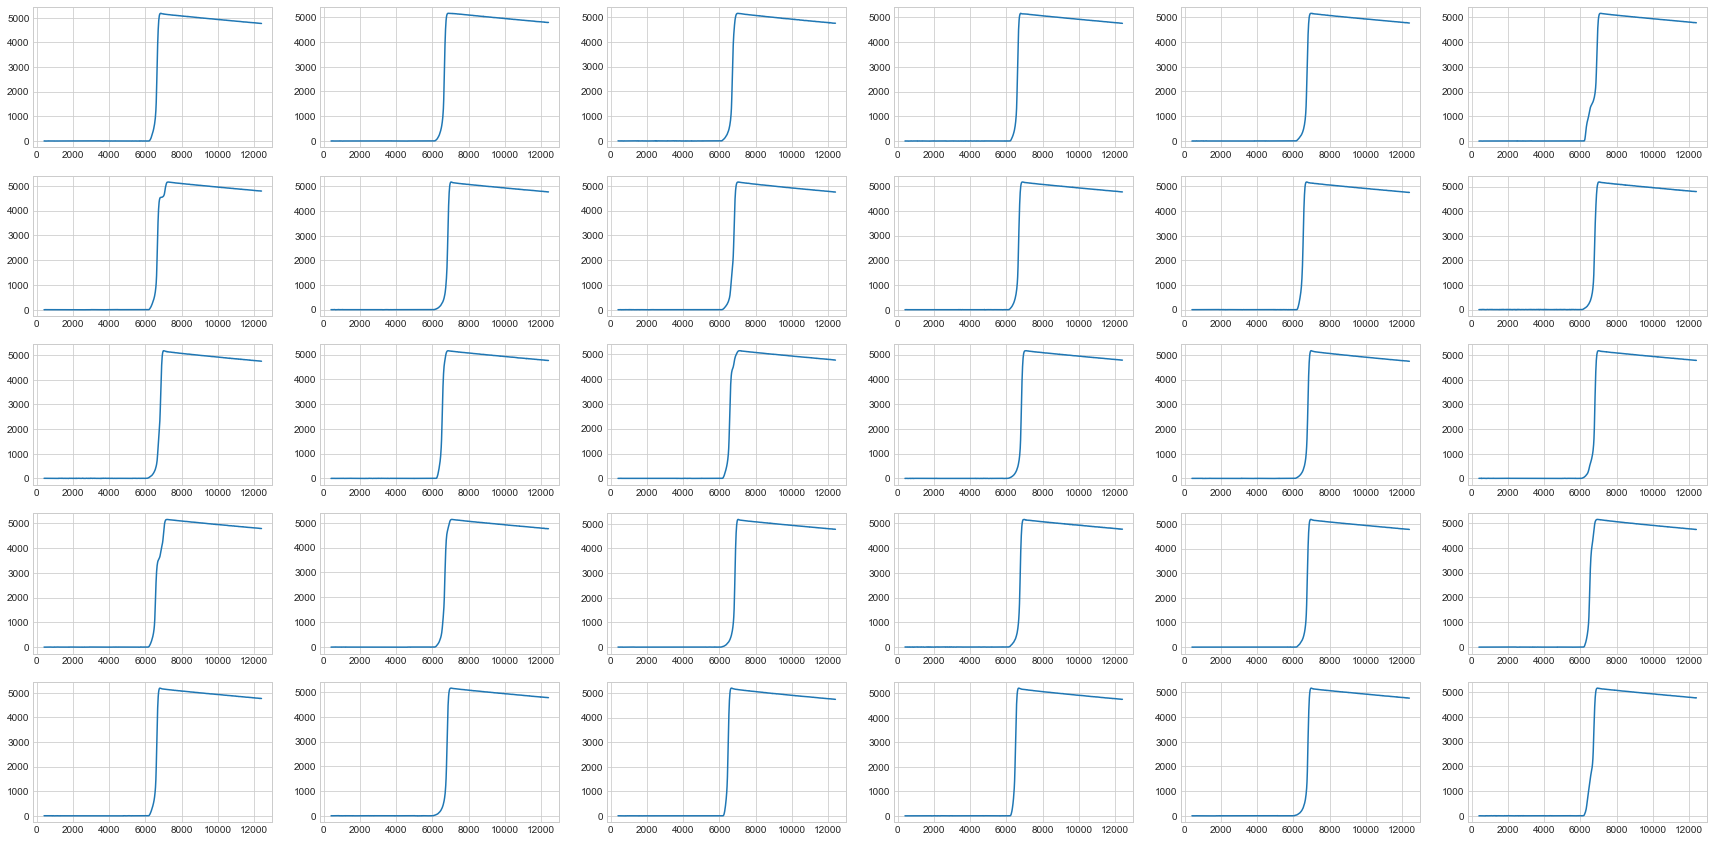

In [9]:
# Draw some multi-site waveforms -- make sure they're multi-site (they're not really...)
waveTS = np.linspace(4000, len(wave_cols)*10+400, len(wave_cols))

# Randomly permutate the index of the dataframe to select some random waveforms
rndperm = np.random.permutation(dfMulti.index.values)

fig1 = plt.figure( figsize=(30,15) )
for i in range(0,30):
    ax = fig1.add_subplot(5,6,i+1)
    ax.plot(waveTS, dfMulti.loc[rndperm[i],wave_cols].values)

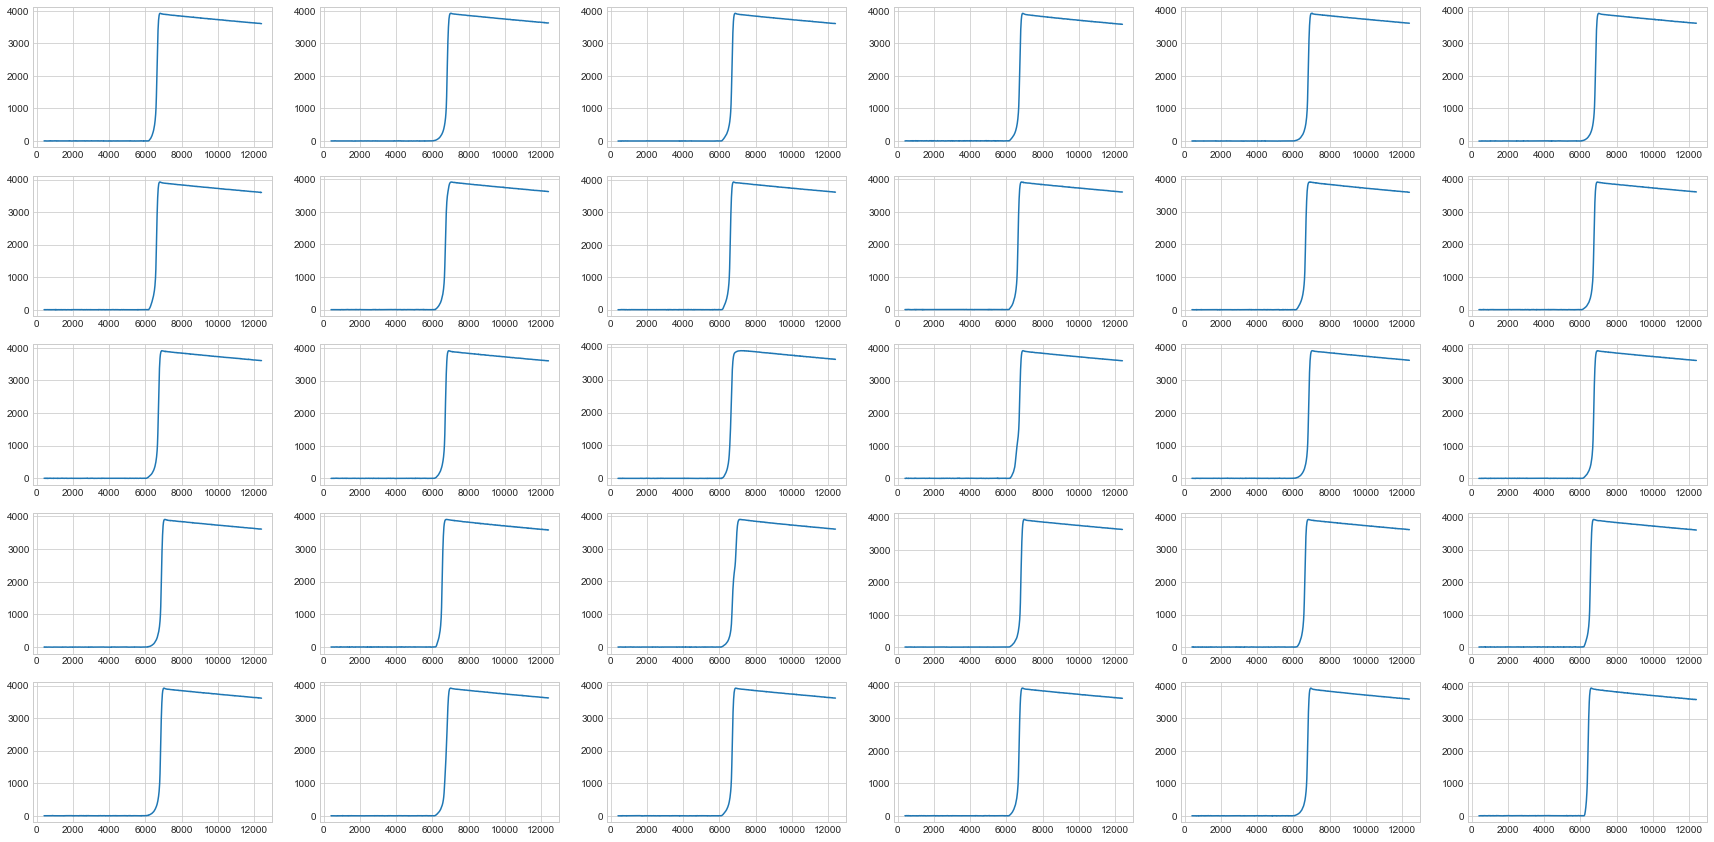

In [10]:
# Draw some single-site waveforms -- make sure they're single-site
# Randomly permutate the index of the dataframe to select some random waveforms
rndperm2 = np.random.permutation(dfSingle.index.values)

fig2 = plt.figure( figsize=(30,15) )
for i in range(0,30):
    ax2 = fig2.add_subplot(5,6,i+1)
    ax2.plot(waveTS, dfSingle.loc[rndperm2[i],wave_cols].values)

In [18]:
# Split up training data for testing
# sklearn has a simple function for doing this
from sklearn.model_selection import train_test_split

# Combine the multi and single into one total dataframe
TotalDF = pd.concat([dfSingle,dfMulti])
TotalDF.head()
print (TotalDF.shape)

# Split it twice, first split creates development (with 85% of data) and evaluation set
# 2nd split is for training sample and test sample
DF_dev, DF_eval = train_test_split(TotalDF, test_size=0.15, random_state=42)
DF_train, DF_test = train_test_split(DF_dev, test_size=0.15, random_state=492)

# Print out how many events are left by the shape
print(DF_dev.shape[0], DF_eval.shape[0], DF_train.shape[0], DF_test.shape[0])

(4900, 1211)
((4165, 1211), (735, 1211), (3540, 1211), (625, 1211))
['index' 'C' 'avse' ..., 'wave998' 'wave999' 'Truth']


In [19]:
# Import basic neural network classifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, roc_auc_score
# Normalization and scaling of data before using it in machine learning
from sklearn import preprocessing

In [24]:
# MLP -- hidden layer sizes: N, N-1

MLP = MLPClassifier(solver='adam', activation='tanh', alpha=1e-5, hidden_layer_sizes=(1201, 1200), random_state=1, max_iter=500, verbose=True)
# For the "fit" function, sklearn takes a X and Y input
# X = a matrix with all of the training parameters; Y = array with truth values only
MLP.fit( DF_train.loc[:,wave_cols].values, DF_train['Truth'] )

Iteration 1, loss = 2.85330947
Iteration 2, loss = 0.71251259
Iteration 3, loss = 0.69149843
Iteration 4, loss = 0.68509861
Iteration 5, loss = 0.68501820
Iteration 6, loss = 0.68324352
Iteration 7, loss = 0.68347797
Iteration 8, loss = 0.69035099
Iteration 9, loss = 0.68374657
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1201, 1200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [25]:
# Assess the performance:
from sklearn.metrics import classification_report, roc_auc_score

acc_MLP = round(MLP.score(DF_train.loc[:,wave_cols].values, DF_train['Truth'])*100,2)
print(acc_MLP)

# There's too few events to really get a good training for multi-site events
Y_test = MLP.predict(DF_test.loc[:,wave_cols].values)
print classification_report(DF_test['Truth'], Y_test,
                            target_names=["Multi-site", "Single-site"])
print MLP.predict_proba(DF_test.loc[:,wave_cols].values)

42.71
             precision    recall  f1-score   support

 Multi-site       0.00      0.00      0.00       365
Single-site       0.42      1.00      0.59       260

avg / total       0.17      0.42      0.24       625

[[ 0.48519241  0.51480759]
 [ 0.48519241  0.51480759]
 [ 0.48519241  0.51480759]
 ..., 
 [ 0.48519241  0.51480759]
 [ 0.48519241  0.51480759]
 [ 0.48519241  0.51480759]]


In [23]:
from sklearn.metrics import roc_curve
decisions = MLP.decision_function(DF_test.loc[:,wave_cols].values)

# Compute ROC curve and area under the curve
# fpr, tpr, thresholds = roc_curve(y_test, decisions)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.grid()
# plt.show()


AttributeError: 'MLPClassifier' object has no attribute 'decision_function'